## Triangulating to the data distribution

Instead of simply triangulating all the points, we can develop a triangulation that has a more uniform distribution of points but that adjusts to represent the density of samples. 

We refine a coarse triangulation with the target of having a maximum number of points per triangle (or density of points around a given vertex) subject to a minimum triangle size.

In [1]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
## Assuming the previous notebook was run, 
data = np.load("AlaskaMoho.npz")
moho_data = data['alaska_moho']

In [3]:
datagrid = stripy.sTriangulation(np.radians(moho_data['lon']), np.radians(moho_data['lat']), permute=True)
print("Points in triangulation: {}".format(datagrid.npoints))

Points in triangulation: 381


In [4]:
## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=4, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 
nodes = np.where(angles < np.radians(20.0))

grid1 = stripy.sTriangulation(grid1r.lons_map_to_wrapped(grid1r.lons[nodes])%(2.0*np.pi), grid1r.lats[nodes], permute=True)



In [5]:
import gdal

globalrelief      = gdal.Open("/Users/lmoresi/+Github/UoM-VIEPS-Intro-to-Python/Data/Resources/HYP_50M_SR_W/HYP_50M_SR_W.tif")
globalrelief_img  = globalrelief.ReadAsArray().transpose(1,2,0)

globaletopobw       = gdal.Open("/Users/lmoresi/+Github/UoM-VIEPS-Intro-to-Python/Data/Resources/etopo1_grayscale_hillshade.tif")
globaletopobw_img   = globaletopobw.ReadAsArray()[::1,::1] / 256.0

In [6]:
ocean = cartopy.feature.OCEAN

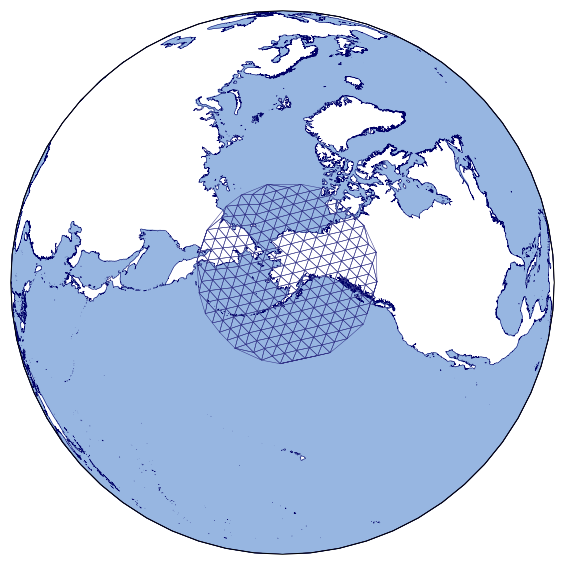

In [7]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=-160, central_latitude=60))
# ax  = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-160))

ax.set_extent([-175,-130,50,72])
ax.set_global()
global_extent = [-180,180,-90,90]

grid = grid1

ax.coastlines(resolution="10m",color="#000066", linewidth=0.5)
ax.add_feature(ocean)


lons0 = np.degrees(grid.lons)
lats0 = np.degrees(grid.lats)
moho  = moho_data['moh']

## Triangulation

for tri in grid1.simplices: 
    ax.plot( [lons0[tri[0]], lons0[tri[1]], lons0[tri[2]], lons0[tri[0]]],
             [lats0[tri[0]], lats0[tri[1]], lats0[tri[2]], lats0[tri[0]]],
             linewidth=0.5,
             color="#333388", transform=ccrs.PlateCarree(), zorder=2 )



## Adjust triangulation

Instead we try building a mesh that has a variable resolution but limits the smallest triangle (by area, for example). Our criterion for refining the mesh is that there are too many data points in the neighbourhood of a given point. But we don't keep going forever - if the triangles get too small, we should stop. 

The refinement strategy is uniform around a node and that can leave us with nodes in the mesh that have no data points in the surrounding triangles. These are removed at each stage. 

This is something that requires some oversight - the algorithm is not clever in any way. It adds points and removes points and can get stuck adding and removing the same point. 



In [8]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):

    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!

    for i in range(0, len(data)):

        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count

In [9]:
grids = [grid1]

lons = moho_data['lon']
lats = moho_data['lat']
moho = moho_data['moh']

for i in range(0, 20):

    ## First refine
    
    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), moho, grids[-1])
    
    node_area = np.zeros(grids[-1].npoints)
    t_areas = grids[-1].areas()

    for t,simplex in enumerate(grids[-1].simplices):
        node_area[simplex] += t_areas[t] 
  
    node_area /= node_area.max()
    
    ## Conditions on weighted average & min area 
    vertices = np.where(np.logical_and(norm > 3.0, node_area > 0.0001))[0]

    print( "Vertices to refine: {}/{}, weights max:{}, counts max:{}, min area: {}".format(
            vertices.shape[0], grids[-1].npoints,
            norm.max(), count.max(), node_area.min() ) )
    
    if vertices.shape[0] != 0: 
        newlons, newlats = grids[-1].centroid_refine_triangulation_by_vertices(vertices=vertices)
        # rgrid = stripy.sTriangulation(grids[-1].lons_map_to_wrapped(newlons), newlats, permute=True, tree=False)
        rgrid = stripy.sTriangulation(newlons, newlats, permute=False)


        grids.append(rgrid)
       
    else:        
        break


    
ave_data, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), moho, grids[-1])


Vertices to refine: 28/232, weights max:34.8727948684, counts max:93, min area: 0.459484433632
Vertices to refine: 39/315, weights max:18.7669611781, counts max:45, min area: 0.246910099183
Vertices to refine: 24/436, weights max:9.92546803551, counts max:27, min area: 0.0814096918639
Vertices to refine: 13/530, weights max:6.52002358678, counts max:14, min area: 0.0274301439634
Vertices to refine: 3/588, weights max:4.14023635384, counts max:9, min area: 0.00771606641796
Vertices to refine: 2/604, weights max:3.49718411348, counts max:8, min area: 0.00304917946521
Vertices to refine: 1/615, weights max:4.50100769967, counts max:8, min area: 0.000926973588145
Vertices to refine: 1/621, weights max:3.40090402926, counts max:8, min area: 0.000357517851856
Vertices to refine: 0/627, weights max:2.99909239877, counts max:8, min area: 0.000135003386012


In [10]:
tgrids = [grid1]

lons = moho_data['lon']
lats = moho_data['lat']
moho = moho_data['moh']

in_triangle = tgrids[-1].containing_triangle(np.radians(lons), np.radians(lats))
tris, counts = np.unique(in_triangle, return_counts=True)

areas = grids[-1].areas()

max_depth = 20
target = 2

while counts.max() > target and max_depth:
    tris_to_refine = np.logical_and(counts > target, areas[tris]>0.000001)
    
    if len(np.nonzero(tris_to_refine)[0]) == 0:
        break

    
    new_lons, new_lats = tgrids[-1].edge_refine_triangulation_by_triangles(tris[tris_to_refine])
    new_grid = stripy.sTriangulation(new_lons%(2.0*np.pi), new_lats, permute=False)
    
    in_triangle = new_grid.containing_triangle(np.radians(lons), np.radians(lats))
    tris, counts = np.unique(in_triangle, return_counts=True)
    areas = new_grid.areas()
    
    tgrids.append(new_grid)
    
    print counts.max(), len(np.nonzero(tris_to_refine)[0]), areas.min(), areas.mean()

    max_depth -= 1
        
    
ave, gnorm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), moho, grids[-1])


13 48 0.0 0.000568220262301017
6 38 0.0 0.0004414743892564326
6 25 0.0 0.0003796299166235401
5 10 0.0 0.00035657546824559907
5 4 0.0 0.00034811913303029016


In [11]:
## Two alternate choices of "good" grids

print("Triangle spliting: {} nodes \nNode splitting: {} nodes".format(tgrids[-1].npoints, grids[-1].npoints))

## Choose one to use later

goodgrid = grids[-1] # grids[-1] or tgrids[-1]

Triangle spliting: 519 nodes 
Node splitting: 627 nodes


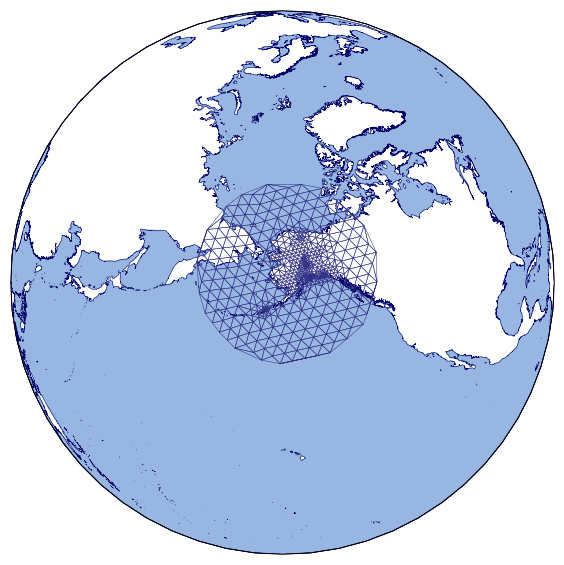

In [12]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=-160, central_latitude=60))
# ax  = plt.subplot(111, projection=ccrs.PlateCarree() )

ax.set_extent([-175,-130,50,72])
ax.set_global()
# global_extent = [-180,180,-90,90]

ax.coastlines(resolution="10m",color="#000066", linewidth=0.5)
ax.add_feature(ocean)

lons0 = np.degrees(goodgrid.lons%(2.0*np.pi))
lats0 = np.degrees(goodgrid.lats)

## Triangulation

for tri in goodgrid.simplices: 
    ax.plot( [lons0[tri[0]], lons0[tri[1]], lons0[tri[2]], lons0[tri[0]]],
             [lats0[tri[0]], lats0[tri[1]], lats0[tri[2]], lats0[tri[0]]],
             linewidth=0.5,
             color="#333388", transform=ccrs.PlateCarree(), zorder=2 )



In [13]:

lons = moho_data['lon']
lats = moho_data['lat']
moho = moho_data['moh']

ave, gnorm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), moho, goodgrid)

## This grid is a reasonable one which represents the data non-uniformly 
## but also lumps together data points that are extremely close to each other. 

## Save this information

np.savez("AlaskaMohoLumped.npz", goodgrid_lons=goodgrid.lons,  goodgrid_lats=goodgrid.lats, 
         ave_data=ave, norm_data=gnorm)


In [14]:
## Patch in additional information where there is no contraint ... 

In [15]:
import litho1pt0

ave0 = ave.copy()

unconstrained_locations = np.where(gnorm == 0.0)

unknown_lons_deg = np.degrees(goodgrid.lons[unconstrained_locations])%360.0
unknown_lats_deg = np.degrees(goodgrid.lats[unconstrained_locations])

c2 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="LID-TOP")
c1 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="CRUST1-TOP")

ave[unconstrained_locations] = (c2-c1) * 0.001 ## Convert to km

# print (c2-c1) * 0.001


In [16]:
## This is a smoothed version of the gridded data - the smoothing operator is taken from ssrfpack 
## The weights indicate the confidence in the data. For points that have few constraints, the weight 
## might well be lower but, perhaps, the variance should also play a role ... 

weights = 0.01 + gnorm #  / gnorm.max()

## third parameter (sm) should be set close to npoints when weights are the 
## standard deviation of the

smooth_d_0001, deriv_d_0001 = goodgrid.smoothing(ave, weights, 0.001*goodgrid.npoints, 0.5, 0.0001)
smooth_d_05, deriv_d_05 = goodgrid.smoothing(ave, weights, 5.0*goodgrid.npoints, 0.5, 0.0001)
smooth_d_10, deriv_d_10 = goodgrid.smoothing(ave, weights, 10.0*goodgrid.npoints, 0.5, 0.0001)
smooth_d_15, deriv_d_15 = goodgrid.smoothing(ave, weights, 15.0*goodgrid.npoints, 0.5, 0.0001)



In [17]:
pt = 207

print ave[pt], gnorm[pt]
print smooth_d_0001[pt]
print smooth_d_05[pt]
print smooth_d_10[pt]
print smooth_d_15[pt]


# 35.152672
# 43.169456
# 40.02625
# 39.61589

28.51257666108352 0.0
28.512815
28.123177
27.026276
36.45768


In [18]:
node_area = np.zeros(goodgrid.npoints)
t_areas = goodgrid.areas()

for t,simplex in enumerate(goodgrid.simplices):
    node_area[simplex] += t_areas[t] 

node_area /= node_area.min()

interpolation_quality = np.minimum(gnorm, 1.0) / np.sqrt(node_area)
interpolation_quality, dd = goodgrid.smoothing(interpolation_quality, weights, 0.001*goodgrid.npoints, 0.25, 0.0001)
interpolation_quality /= interpolation_quality.mean()

In [19]:
node_area_r = np.zeros(datagrid.npoints)
t_areas = datagrid.areas()

for t,simplex in enumerate(datagrid.simplices):
    node_area_r[simplex] += t_areas[t] 

node_area_r /= node_area_r.max()

interpolation_quality_r = 1.0 / node_area_r

In [20]:
## Map everything to a regular triangulation for plotting and to demonstrate how interpolation works.

## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, refinement_levels=8, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

lons1 = grid1r.lons[nodes]%(2.0*np.pi)
lats1 = grid1r.lats[nodes]

# identify points within X degrees of a data point

grid1 = stripy.sTriangulation(datagrid.lons, datagrid.lats, tree=True)
near_nodes, distances = grid1.nearest_vertex(lons1, lats1) 
nodes = np.where(distances < 0.075)[0]

# # Now identify points within triangles

# i, err = datagrid.interpolate(lons1, lats1, np.ones_like(datagrid.lons))
# nodes = np.where(err==0)

gridF = stripy.sTriangulation(lons1[nodes]%(2.0*np.pi), lats1[nodes], permute=True)

# Use this as a quality measure 

distances_k, near_nodes = grid1.nearest_vertices(gridF.lons, gridF.lats, k=10) 
distances = distances_k.mean(axis=1)
interpolation_quality_d = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())


In [21]:
gridF_interpolation_d_0001, err = goodgrid.interpolate(gridF.lons, gridF.lats, smooth_d_0001, order=3)
gridF_interpolation_d_05, err = goodgrid.interpolate(gridF.lons, gridF.lats, smooth_d_05, order=3)
gridF_interpolation_d_10, err = goodgrid.interpolate(gridF.lons, gridF.lats, smooth_d_10, order=3)
gridF_interpolation_d_15, err = goodgrid.interpolate(gridF.lons, gridF.lats, smooth_d_15, order=3)


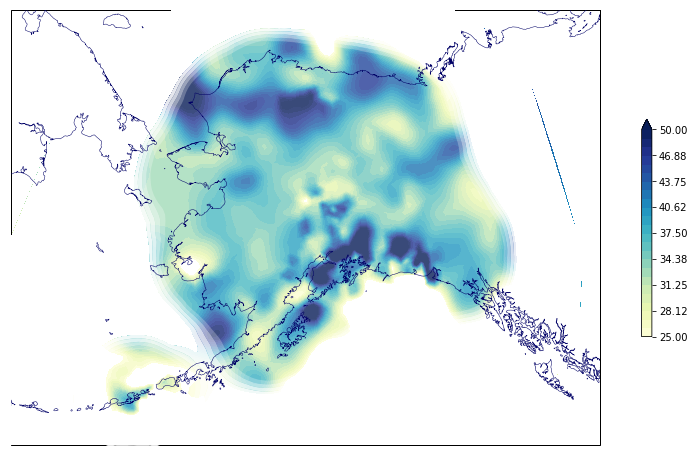

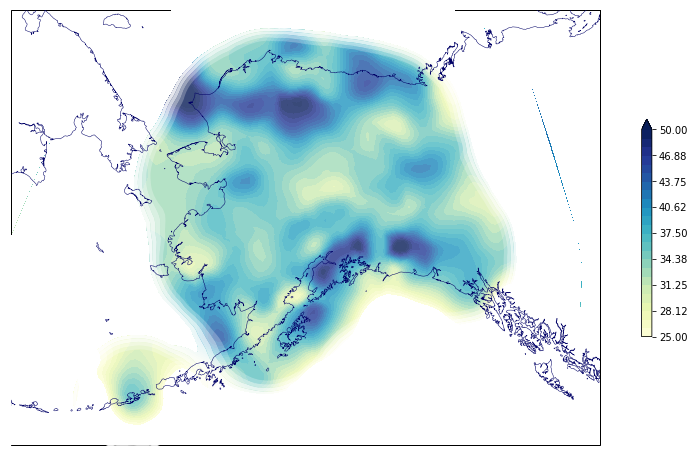

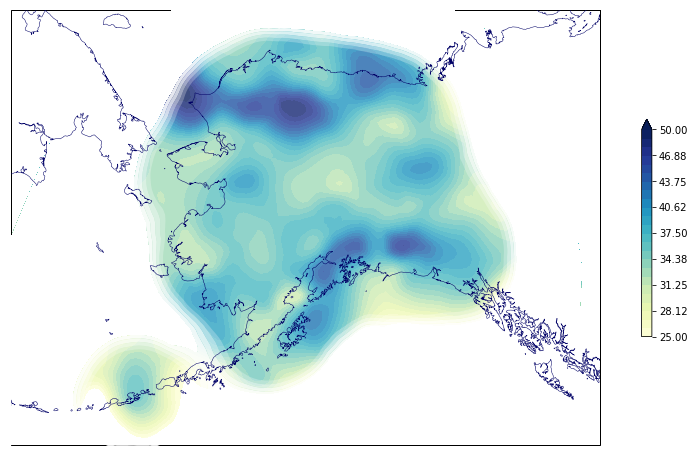

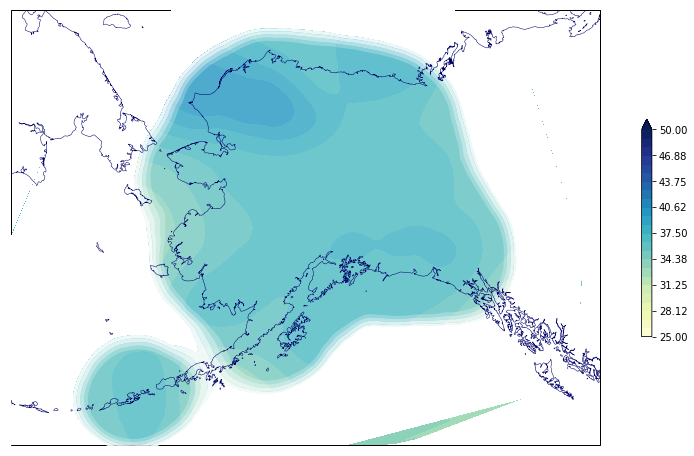

In [27]:
def alaska_plot2(filename, grid, data, quality, plot_range=[25.0, 50.0], cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-175,-130,50,72])
    ax1.coastlines(resolution="10m",color="#000066", linewidth=0.5, zorder=99)

    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, grid_data, 
                   cmap=cmap, alpha=1.0, levels=np.linspace(plot_range[0], plot_range[1], 25),
                   extend="max", 
                   transform=ccrs.PlateCarree(), zorder=0)
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt0.collections:
        c.set_linewidth(0.0)
        c.set_edgecolor("None")

    ## Mask by "quality" of the interpolation
    
    cnt1 = ax1.tricontourf(lons, lats, goodgrid.simplices, interpolation_quality, 
                       levels=[ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 1.0],
                       colors=[(1.0,1.0,1.0,1.0), (1.0,1.0,1.0,0.9),
                               (1.0,1.0,1.0,0.8), (1.0,1.0,1.0,0.6),
                               (1.0,1.0,1.0,0.4),(1.0,1.0,1.0,0.2),
                               (1.0,1.0,1.0,0.0)], extend="both",
                       transform=ccrs.PlateCarree(), zorder=10)  
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt1.collections:
        c.set_edgecolor("#00000000")
        c.set_linewidth(0.0)

    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

    from PIL import ImageChops
    from PIL import Image
    import io, os
    
    filename_base, filename_ext = os.path.splitext(filename)

    im_buffer = io.BytesIO()
    fig.savefig(im_buffer, format='png', dpi=600)
    
    im_buffer.seek(0)
    im = Image.open(im_buffer)

    imbg = Image.open("AlaskaMohoImgBg.png")
    imblend = ImageChops.multiply(imbg,im)
    imblend.save("{}+bg.png".format(filename_base))
    im_buffer.close()
    
    return

alaska_plot2("MSM-AlaskaMoho-Fitted_Moho_00.png", gridF, gridF_interpolation_d_0001, interpolation_quality_d, plot_range=[25, 50], cmap=plt.cm.YlGnBu)
alaska_plot2("MSM-AlaskaMoho-Fitted_Moho_05.png", gridF, gridF_interpolation_d_05,   interpolation_quality_d, plot_range=[25, 50], cmap=plt.cm.YlGnBu)
alaska_plot2("MSM-AlaskaMoho-Fitted_Moho_10.png", gridF, gridF_interpolation_d_10,   interpolation_quality_d, plot_range=[25, 50], cmap=plt.cm.YlGnBu)
alaska_plot2("MSM-AlaskaMoho-Fitted_Moho_15.png", gridF, gridF_interpolation_d_15,   interpolation_quality_d, plot_range=[25, 50], cmap=plt.cm.YlGnBu)
